# **Divergent Scores: An In-Depth Analysis of SAT Performance Across NYC Boroughs**

![New York City schoolbus](schoolbus.jpg)

Photo by [Jannis Lucas](https://unsplash.com/@jannis_lucas) on [Unsplash](https://unsplash.com).
<br>

Every year, American high school students take SATs, which are standardized tests intended to measure literacy, numeracy, and writing skills. There are three sections - reading, math, and writing, each with a **maximum score of 800 points**. These tests are extremely important for students and colleges, as they play a pivotal role in the admissions process.

Analyzing the performance of schools is important for a variety of stakeholders, including policy and education professionals, researchers, government, and even parents considering which school their children should attend. 

In this project, we will delve into the `schools.csv` dataset to explore and analyze the SAT performance of New York City (NYC) public schools. 


The first part of the project (which corresponds to the version available on DataCamp) focuses on conducting an exploratory analysis to answer three fundamental questions:

- Which NYC schools have the best math results?
- What are the top 10 performing schools based on the combined SAT scores?
- Which single borough has the largest standard deviation in the combined SAT score?


Building upon this exploratory groundwork, the project has been expanded into a comprehensive data science study by addressing three  research questions:

- *Understanding the relationship between Borough and Average SAT scores* - Utilizing a statistica; test (Analysis of Variance (ANOVA) - parametric or Kruskal-Wallis Test - nonparametric) to determine if there are significant differences in SAT scores across different boroughs.
- *Exploring the relationship between percentage of students tested and Average SAT scores* - Applying a regression models to investigate if the average SAT scores can be predicted by the percentage of students who take the SAT exams. This will help understand the impact of test participation on performance.
- *Identifying Outlier Schools* - Using outlier and anomaly detection methods to identify schools that significantly deviate from the norm. This can reveal insights into schools that are overperforming or underperforming.


In [2]:
%pip install scikit_posthocs
%pip install pygam

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 64.7 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [3]:
# Standard library imports
import numpy as np

# Data manipulation
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
import scipy.stats as stats
from scipy.stats import chi2, shapiro, ks_2samp
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.stats.multicomp import MultiComparison
import scikit_posthocs as sp

# Machine learning preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

# Machine learning model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Machine learning models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pygam import LinearGAM, s

# Machine learning pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:
# Read in the data
schools = pd.read_csv("schools.csv")

# Preview the data
schools.head()

,school_name,borough,building_code,average_math,average_reading,average_writing,percent_tested
0,"New Explorations into Science, Technology and ...",Manhattan,M022,657,601,601,NaN
1,Essex Street Academy,Manhattan,M445,395,411,387,78.9
2,Lower Manhattan Arts Academy,Manhattan,M445,418,428,415,65.1
3,High School for Dual Language and Asian Studies,Manhattan,M445,613,453,463,95.9
4,Henry Street School for International Studies,Manhattan,M056,410,406,381,59.7


In [5]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_name      375 non-null    object 
 1   borough          375 non-null    object 
 2   building_code    375 non-null    object 
 3   average_math     375 non-null    int64  
 4   average_reading  375 non-null    int64  
 5   average_writing  375 non-null    int64  
 6   percent_tested   355 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 20.6+ KB


## EDA (Exploratory data analysis)

In [6]:
# Which NYC schools have the best math results?
best_math_schools=round(schools[["school_name","average_math"]].query("average_math >= (80*800/100)").sort_values("average_math", ascending=False), 2)
best_math_schools

,school_name,average_math
88,Stuyvesant High School,754
170,Bronx High School of Science,714
93,Staten Island Technical High School,711
365,Queens High School for the Sciences at York Co...,701
68,"High School for Mathematics, Science, and Engi...",683
280,Brooklyn Technical High School,682
333,Townsend Harris High School,680
174,High School of American Studies at Lehman College,669
0,"New Explorations into Science, Technology and ...",657
45,Eleanor Roosevelt High School,641


In [7]:
# What are the top 10 performing schools based on the combined SAT scores?
schools["total_SAT"]=schools["average_math"] + schools["average_reading"] + schools["average_writing"]

top_10_schools=round(schools[["school_name", "total_SAT"]].sort_values("total_SAT", ascending=False).nlargest(10, "total_SAT"), 2)
top_10_schools

,school_name,total_SAT
88,Stuyvesant High School,2144
170,Bronx High School of Science,2041
93,Staten Island Technical High School,2041
174,High School of American Studies at Lehman College,2013
333,Townsend Harris High School,1981
365,Queens High School for the Sciences at York Co...,1947
5,Bard High School Early College,1914
280,Brooklyn Technical High School,1896
45,Eleanor Roosevelt High School,1889
68,"High School for Mathematics, Science, and Engi...",1889


In [8]:
# Which single borough has the largest standard deviation in the combined SAT score?
largest_std_dev=round(schools.groupby("borough").agg(num_schools=("school_name", "count"),
                                                     average_SAT=("total_SAT", "mean"),
                                                     std_SAT=("total_SAT", "std")). sort_values("std_SAT", ascending=False).nlargest(1, "std_SAT"), 2)
largest_std_dev

,num_schools,average_SAT,std_SAT
borough,,,
Manhattan,89,1340.13,230.29


---
## Project Design

**Research questions:**
1. Does the borough have an impact on the average SAT scores (Math, Reading, Writing)?
2. Is there a correlation between the percentage of students tested and the average SAT scores?
3. Are there schools that are outliers in terms of SAT scores?

**Variables of interest**
- Dependent Variables (DV): `total_SAT` => outcome of interest.
- Independent Variables (IV): `borough`, `percent_tested` => predictors

---
### 1. Understanding the relationship between the borough and average SAT scores using Analysis of Variance (ANOVA) - parametric test or Kruskal-Wallis Test - non-parametric test


The choice between using a parametric or non-parametric test is dependent on the results of the normality assumption test.



<table>
<tr>
<th>ANOVA (Parametric Test)</th>
<th>Kruskal-Wallis Test (Non-parametric Test)</th>
</tr>
<tr>
<td valign="top" width="50%">

ANOVA is a statistical test that assesses if there is a significant difference between the means of three or more groups. A one-way ANOVA is a type of statistical test that compares the variance in the group means within a sample whilst considering only one independent variable or factor.

**Hypothesis**:

*Null Hypothesis (H0)*: The means of the average SAT scores are the same across all boroughs. This means that the borough has no impact on the average SAT scores.

$$\mu_1 = \mu_2 = \mu_3 = \ldots = \mu_n$$

$$\text{(where } \mu \text{ is the mean average SAT score for each borough)}$$
    
*Alternative Hypothesis (H1)*: At least one borough has a different average SAT score than the others. This means that the borough does have an impact on the average SAT scores.

$$\text{At least one } \mu \text{ differs from the others}$$

The chosen significance level of **0.05** so if the p-value from the ANOVA test is less than or equal with 0.05, the null hypothesis will be rejected in favor of the alternative hypothesis.

**Assumptions of ANOVA**:
1. **Independence**: The observations are independent of each other. This is usually achieved if the data is collected randomly from the population and the sample size is not more than 10% of the population.
2. **Normality**: The dependent variable residuals are approximately normally distributed for each category of the independent variable. This can be checked using a Q-Q plot or statistical tests like the Shapiro-Wilk test.
3. **Homogeneity of variances**: The variances of the dependent variable are equal across all categories of the independent variable. This can be checked using Levene's test or Bartlett's test.

</td>
<td valign="top" width="50%">

The Kruskal-Wallis Test is a non-parametric alternative to ANOVA that does not assume normality of the data. It ranks all the values from all groups together and then compares the average rank between groups. 

**Hypothesis**:

*Null Hypothesis (H0)*: The median ranks of the average SAT scores are the same across all boroughs.
$$M_1 = M_2 = M_3 = \ldots = M_n$$

This means that the borough has no impact on the average SAT scores.

*Alternative Hypothesis (H1)*: At least one borough has a different median rank of average SAT score than the others.
$$\text{At least one } M_i \text{ is not equal to the others.}$$

This means that the borough does have an impact on the average SAT scores. 
$$\text{In other words, there exists at least one pair } i, j \text{ such that } M_i \neq M_j$$

The chosen significance level of **0.05** so if the p-value from the Kruskal-Wallis Test is less than or equal with 0.05, the null hypothesis will be rejected in favor of the alternative hypothesis. 

**Assumptions of the Kruskal-Wallis Test**:
1. **Independence**: The observations are independent of each other.
2. **Ordinal data**: The dependent variable should be at least ordinal, i.e., it can be logically ordered.
3. **Similar shape distributions**: The shape of the distribution of the dependent variable should be the same for all categories of the independent variable.

</td>
</tr>
</table>


In [9]:
# Looking at the borough groups
boroughs = schools['borough'].unique()
alpha=0.05 # setting significance level to 0.05

scores=['average_math', 'average_reading', 'average_writing', 'total_SAT']
schools['borough'].value_counts()

Brooklyn         109
Bronx             98
Manhattan         89
Queens            69
Staten Island     10
Name: borough, dtype: int64

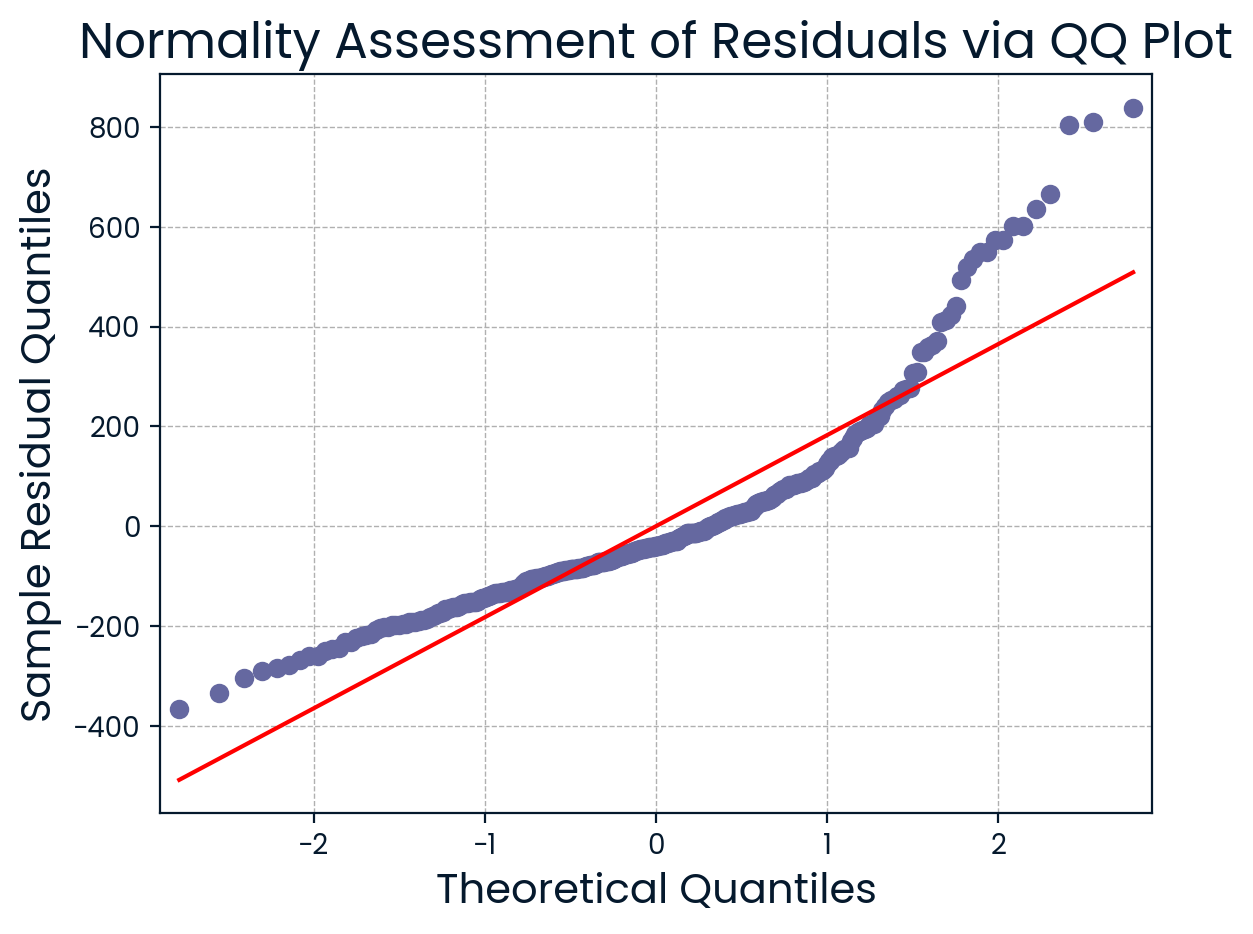

Shapiro-Wilk Test Statistic: 0.860090434551239
P-value: 7.665989798244402e-18


In [10]:
# Testing the normality (2nd assumption of ANOVA)
# Source: https://machinelearningmastery.com/leveraging-anova-and-kruskal-wallis-tests-to-analyze-the-impact-of-the-great-recession-on-housing-prices/

x_qq=pd.get_dummies(schools[['borough']], columns=['borough'])
y_qq = schools['total_SAT']

x_qq1 = sm.add_constant(x_qq)

model = sm.OLS(y_qq, x_qq1)

# Fitting an ordinary least squares model and get residuals
results = model.fit()
residuals = results.resid
 
# Plotting QQ plot - residuals quantiles are expected to follow the red 45 degrees reference line
sm.qqplot(residuals, line='s')
plt.title('Normality Assessment of Residuals via QQ Plot', fontsize=18)
plt.xlabel('Theoretical Quantiles', fontsize=15)
plt.ylabel('Sample Residual Quantiles', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
 
# Shapiro-Wilk Test - p-value<0.05 => null hypothesis rejected => residuals do not follow a normal distribution
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}\nP-value: {shapiro_p}")
normality_check_results= False if shapiro_p<alpha else True

In [11]:
# Checking for homogeneity (3rd assumption of ANOVA)
def check_homogeneity(column):
    group_data = [schools[schools['borough'] == borough][column] for borough in boroughs]
    _, pvalue = stats.levene(*group_data)
    if pvalue > alpha:
        return True # variances of scores across different borough are statistically homogeneous
    else:
        return False

homogeneity_check_results = {}

for score in scores:
    homogeneity_check_results[score] = check_homogeneity(score)
    
  
def one_way_anova(col):
    significant = {}
    borough_data = [schools[schools['borough'] == borough][col] for borough in boroughs]
    fvalue, pvalue = stats.f_oneway(*borough_data)
    print('F-value:', fvalue)
    print('P-value:', pvalue)
    print('')
    if pvalue <= 0.05:
        significant[col]=[fvalue, pvalue]
    return significant

def kruskal_test(col):
    significant = {}
    group_data = [schools[schools['borough'] == borough][col] for borough in boroughs]
    fvalue, pvalue = stats.kruskal(*group_data)
    print('Statistic:', fvalue)
    print('P-value:', pvalue)
    print('')
    if pvalue <= 0.05:
        significant[col]=[fvalue, pvalue]
    return significant

for score in scores:
    print(f'Dependent variable: {score}')
    if normality_check_results and homogeneity_check_results[score]:
        print(f'ANOVA test results')
        significant=one_way_anova(score)
    else:
        print(f'Kruskal test results')
        significant=kruskal_test(score)

Dependent variable: average_math
Kruskal test results
Statistic: 64.07583545128584
P-value: 4.028299824295328e-13

Dependent variable: average_reading
Kruskal test results
Statistic: 54.90649577718638
P-value: 3.3988952409334255e-11

Dependent variable: average_writing
Kruskal test results
Statistic: 53.53675019406242
P-value: 6.579499723736733e-11

Dependent variable: total_SAT
Kruskal test results
Statistic: 59.745768964593935
P-value: 3.280562519175244e-12



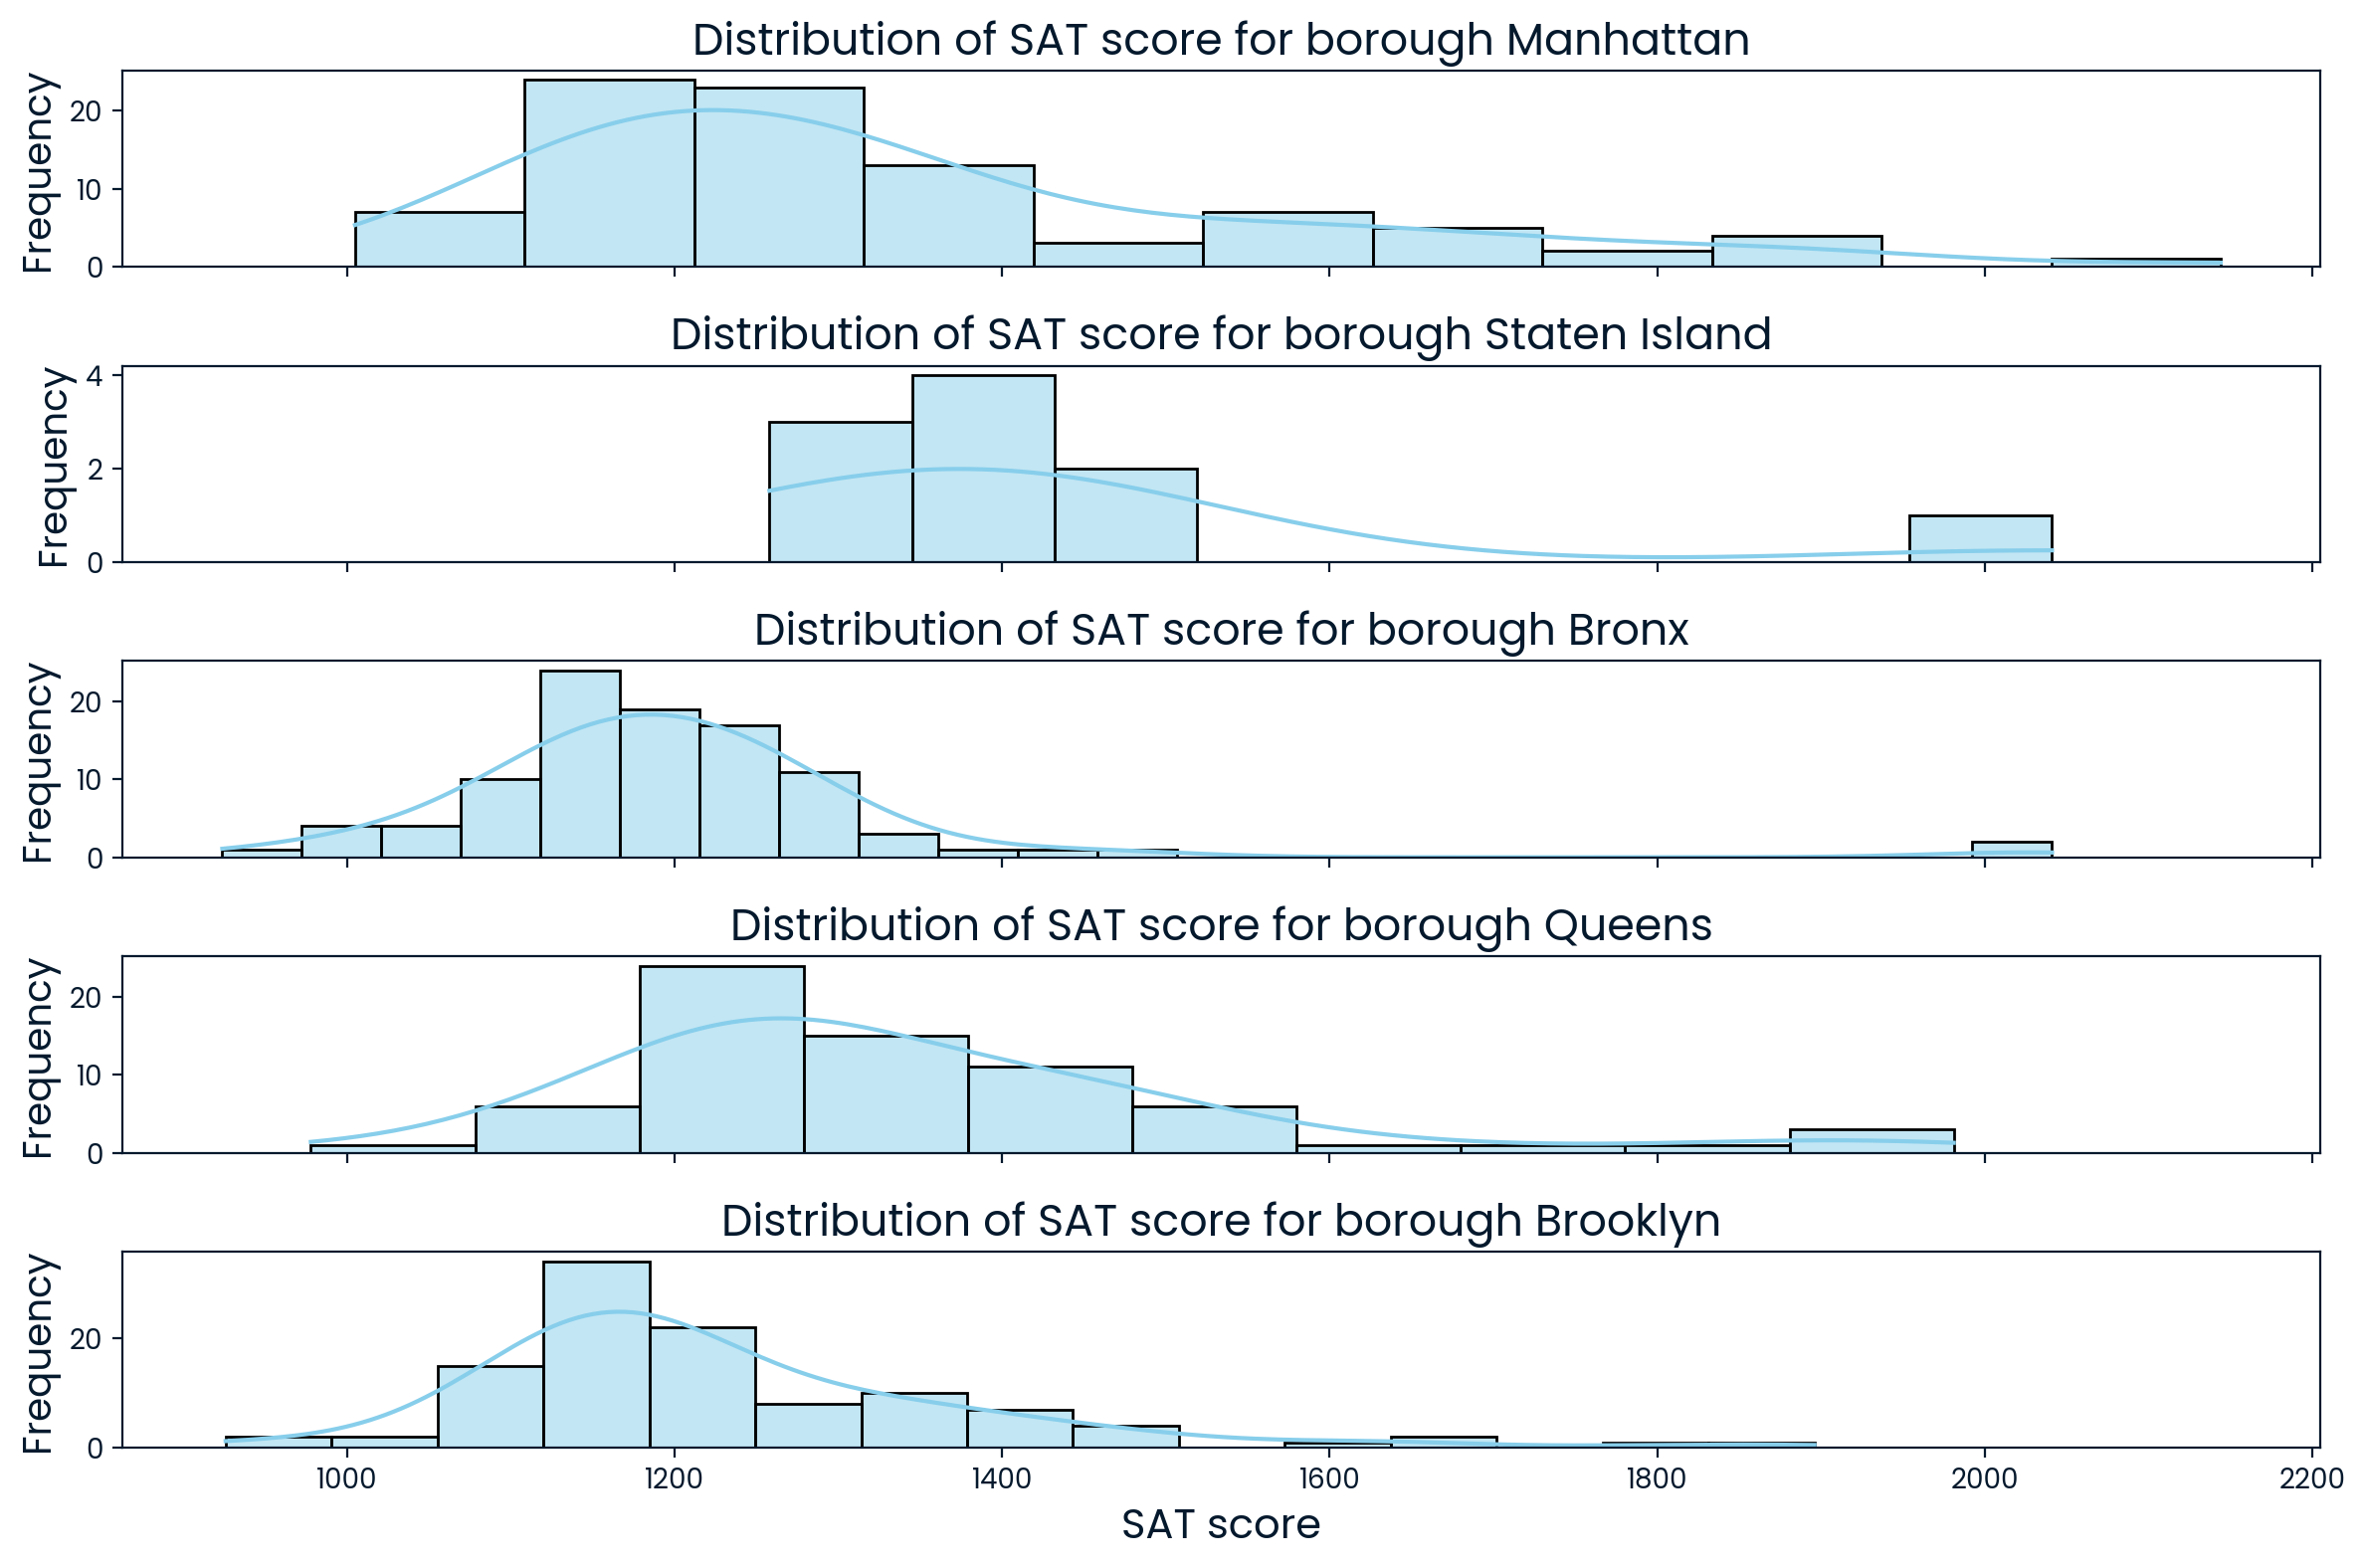

            Boroughs Compared  KS Statistic       P-value
0  Manhattan vs Staten Island      0.471910  2.468976e-02
1          Manhattan vs Bronx      0.391309  6.533351e-07
2         Manhattan vs Queens      0.201922  7.037232e-02
3       Manhattan vs Brooklyn      0.282651  5.843294e-04
4      Staten Island vs Bronx      0.806122  1.232916e-06
5     Staten Island vs Queens      0.423188  6.312713e-02
6   Staten Island vs Brooklyn      0.697248  7.019062e-05
7             Bronx vs Queens      0.449127  6.715527e-08
8           Bronx vs Brooklyn      0.175248  7.120954e-02
9          Queens vs Brooklyn      0.392501  2.365619e-06


In [12]:
# Plotting histograms of total_SAT for each borough for visualize the distributions (3rd assumption of Kruskal-Wallis Test)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
 
for idx, year in enumerate(boroughs):
    sns.histplot(schools[schools['borough'] == year]['total_SAT'], kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Distribution of SAT score for borough {year}', fontsize=16)
    axes[idx].set_ylabel('Frequency', fontsize=14)
    if idx == 4:
        axes[idx].set_xlabel('SAT score', fontsize=15)
    else:
        axes[idx].set_xlabel('')
 
plt.tight_layout()
plt.show()


results = {}
for i, b1 in enumerate(boroughs):
    for j, b2 in enumerate(boroughs):
        if i < j:
            ks_stat, ks_p = ks_2samp(schools[schools['borough'] == b1]['total_SAT'], 
                                     schools[schools['borough'] == b2]['total_SAT'])
            results[f"{b1} vs {b2}"] = (ks_stat, ks_p)
 
# Converting the results into a DataFrame for tabular representation
ks_df = pd.DataFrame(results).transpose()
ks_df.columns = ['KS Statistic', 'P-value']
ks_df.reset_index(inplace=True)
ks_df.rename(columns={'index': 'Boroughs Compared'}, inplace=True)
 
print(ks_df)

In [13]:
# Performing Kruskal-Wallis test
H, pval = stats.kruskal(*[group['total_SAT'] for name, group in schools.groupby('borough')])

# If p-value is significant, perform Dunn's test
if pval < 0.05:
    posthoc = sp.posthoc_dunn(schools, val_col='total_SAT', group_col='borough', p_adjust='bonferroni')
    print(posthoc)


                      Bronx  Brooklyn  Manhattan        Queens  Staten Island
Bronx          1.000000e+00  1.000000   0.000010  5.217726e-08       0.000124
Brooklyn       1.000000e+00  1.000000   0.001230  1.074457e-05       0.001029
Manhattan      1.007649e-05  0.001230   1.000000  1.000000e+00       0.276236
Queens         5.217726e-08  0.000011   1.000000  1.000000e+00       1.000000
Staten Island  1.243583e-04  0.001029   0.276236  1.000000e+00       1.000000


Based on the results of the Dunn’s test, there are significant differences in the median ranks of SAT scores between several pairs of boroughs. 

Specifically, *significant differences were found between*:
- Bronx and Manhattan
- Bronx and Queens
- Bronx and Staten Island
- Brooklyn and Manhattan
- Brooklyn and Queens
- Brooklyn and Staten Island

However, *no significant differences were found between*:
- Manhattan and Staten Island, 
- Bronx and Brooklyn, and 
- Queens and Staten Island.

**Conclusion**: The borough does appear to have an impact on the average SAT scores, as the median ranks of SAT scores differ significantly between several pairs of boroughs.

---
### 2. Understanding the correlation between the percentage of students tested and the average SAT scores using a regression model

To investigate this question, we will:
- split the data into a training set and a test set 
- perform data cleaning and preprocessing steps to prepare the training datase
- identify the relevant features for the model
- train the regression model
- validate the performance of the model (e.g. RMSE (Root Mean Square Error), MAE (Mean Absolute Error))

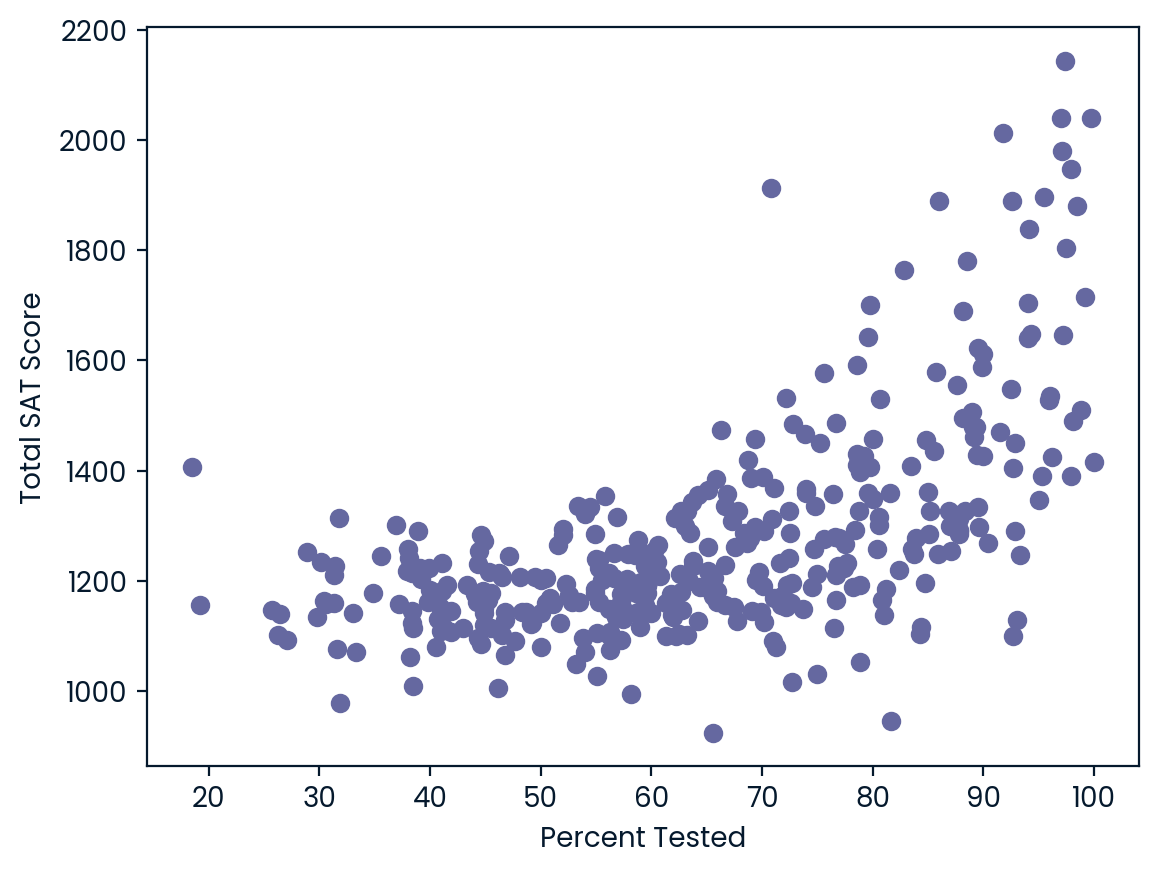

count    374.000000
mean       1.016698
std        0.188259
min        0.483586
25%        0.920318
50%        1.007827
75%        1.093954
max        1.852087
Name: total_SAT, dtype: float64


In [14]:
# Plotting a scatterplot of the relationship between predictor and target variables
plt.scatter(x='percent_tested', y='total_SAT', data=schools.dropna()[['percent_tested', 'total_SAT']])
plt.xlabel('Percent Tested')
plt.ylabel('Total SAT Score')
plt.show()

print((schools['total_SAT'].pct_change() + 1).describe())

# non-constant ratios



#### A. Split the data into training and test sets

In [15]:
X = schools[['percent_tested']]
y = schools[['total_SAT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

#### B. Data Cleaning and Preprocessing

In [16]:
display(X_train.info())

# Calculating the counts and % of missing values
missing_data = X_train.isnull().sum().rename('missing_count')
missing_percent = (X_train.isnull().mean() * 100).rename('missing_%')

missing_df = (pd.concat([missing_data, missing_percent], axis=1)).round(2)
display(missing_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 36 to 102
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   percent_tested  241 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


None

,missing_count,missing_%
percent_tested,10,3.98


In [17]:
# Using MCAR test to check of missing data is MCAR or not

def littles_mcar_test(data):
    data = data.astype(float)
    observed = np.sum(np.sum(data.isnull()))
    expected = data.isnull().mean().mean() * data.size
    columns = data.columns
    binary = np.array([(data[columns[i]].isnull() + data[columns[j]].isnull()) == 1 
                       for i in range(data.shape[1]) 
                       for j in range(i+1, data.shape[1])]).sum()
    chi_squared = (observed - expected + binary) ** 2 / (expected + binary)
    return chi_squared, chi2.sf(chi_squared, binary)


cat_vals=[col for col in X_train.columns if X_train[col].dtypes=='object']

chi_squared, p_value = littles_mcar_test(X_train[X_train.columns.difference(cat_vals)])

alpha = 0.05
print(f"Chi-Squared: {chi_squared}")
print(f"P-Value: {p_value}")

if p_value < alpha:
    print("We reject the null hypothesis. The data are not Missing Completely at Random.")
else:
    print("We fail to reject the null hypothesis. The data are Missing Completely at Random.")

Chi-Squared: 0.0
P-Value: nan
We fail to reject the null hypothesis. The data are Missing Completely at Random.


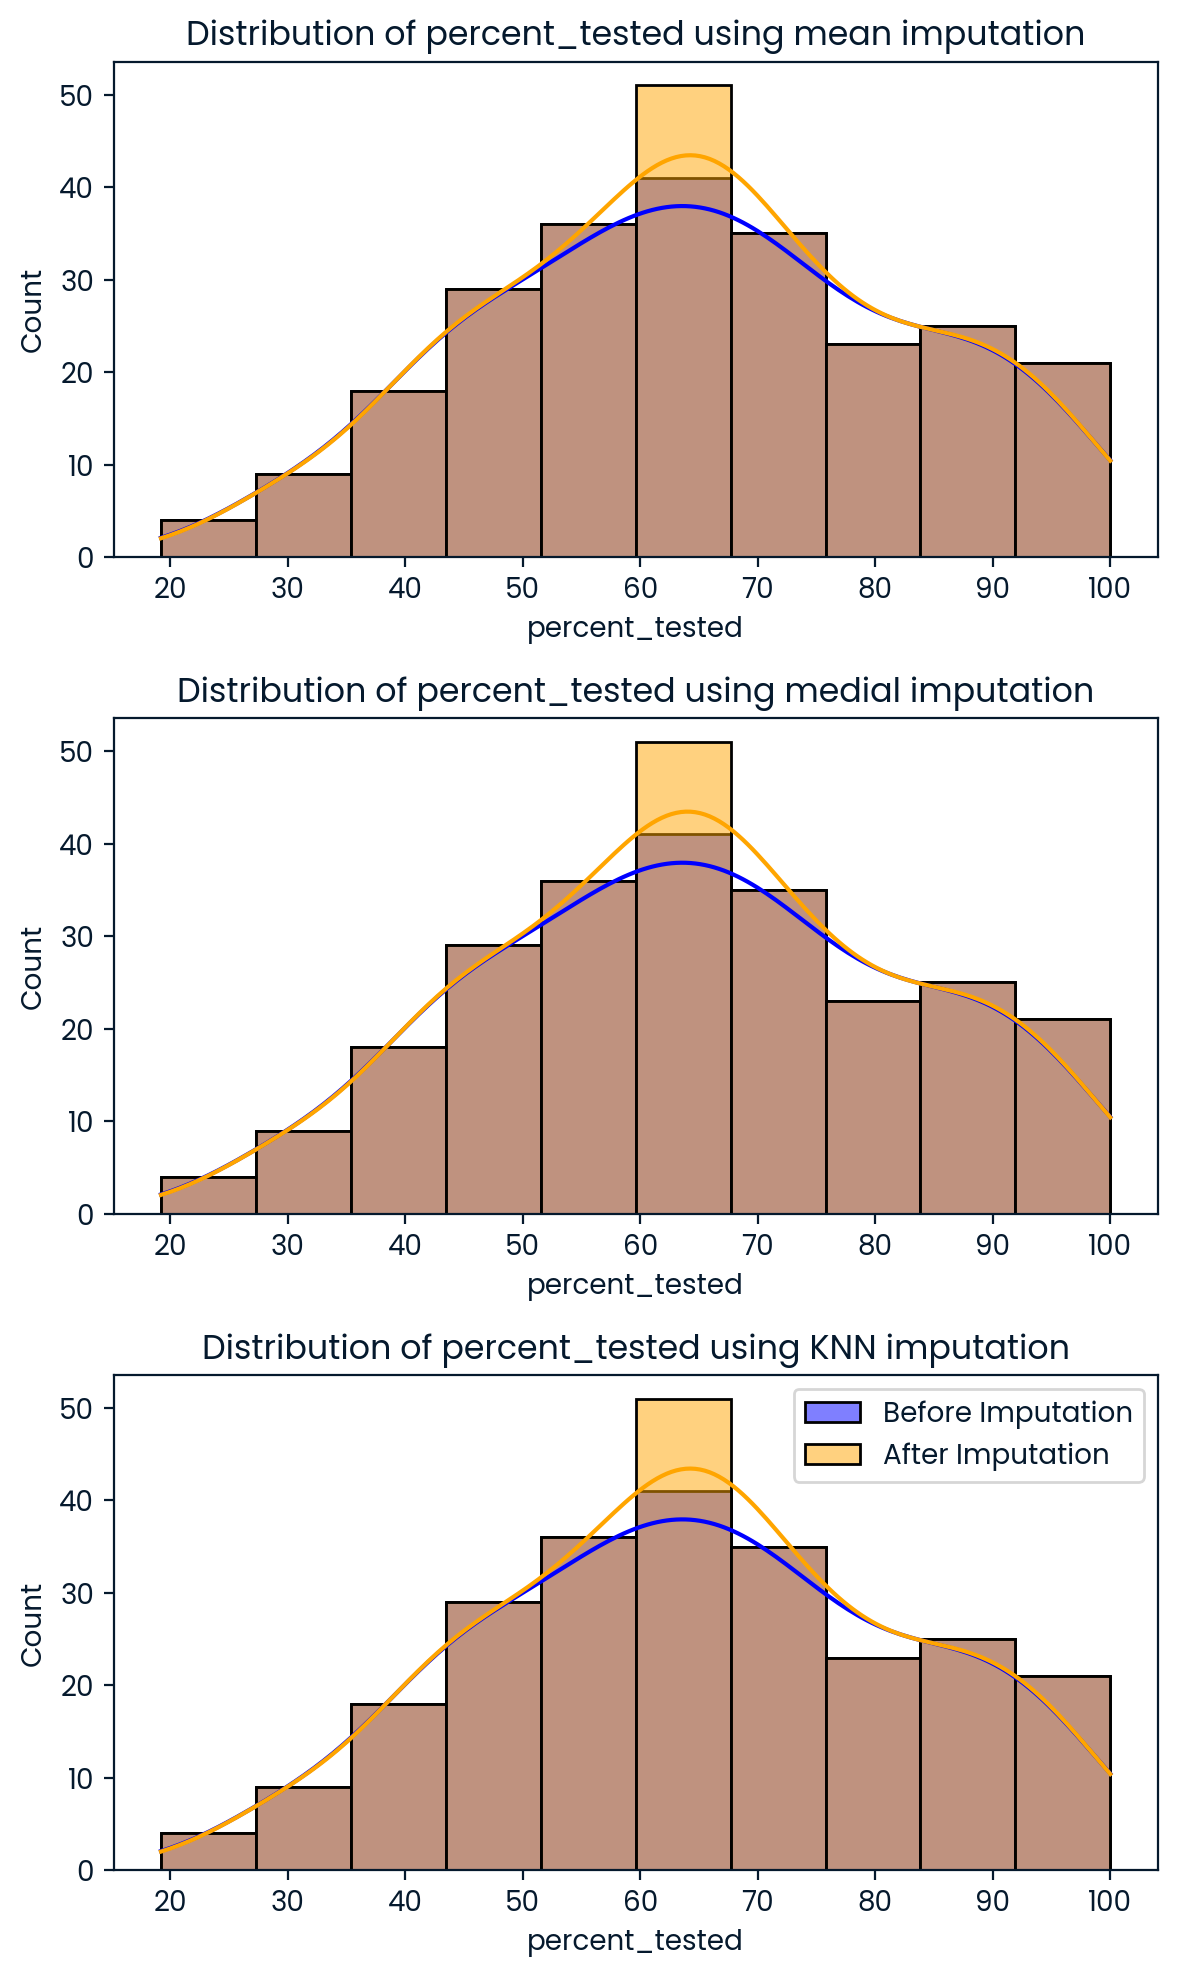

In [18]:
imputers = {"mean": SimpleImputer(strategy='mean'), 
            "medial": SimpleImputer(strategy='median'), 
            "KNN": KNNImputer(n_neighbors=2)}

def plot_imputations(df, cols_to_impute, imputers):
    fig, axes = plt.subplots(nrows=len(imputers), ncols=1, figsize=(6, 10))

    for i, (imputer_name, imputer) in enumerate(imputers.items()):
        imputed = pd.DataFrame(imputer.fit_transform(df[cols_to_impute]), columns=cols_to_impute)
        for feature in cols_to_impute:
            sns.histplot(df[feature], kde=True, ax=axes[i], color='blue', label='Before Imputation')
            sns.histplot(imputed[feature], kde=True, ax=axes[i], color='orange', label='After Imputation')
            axes[i].set_title(f'Distribution of {feature} using {imputer_name} imputation')

    plt.tight_layout()
    plt.legend()
    plt.show()

plot_imputations(X_train, ['percent_tested'], imputers)

In [19]:
# Outliers
def outliers_detect(df, col, outlier_threshold=1.5):
    lower_bound = np.percentile(df[col], 25) - outlier_threshold * (np.percentile(df[col],  75) - np.percentile(df[col], 25))
    upper_bound = np.percentile(df[col], 75) + outlier_threshold * (np.percentile(df[col], 75) - np.percentile(df[col], 25))
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Outliers detected (threshold = {outlier_threshold}): {len(outliers)}")
    return outliers, lower_bound, upper_bound
    
outliers_xtrain, lb_xtrain, up_xtrain=outliers_detect(X_train, 'percent_tested')
outliers_xtrain
outliers_ytrain, lb_ytrain, up_ytrain=outliers_detect(y_train, 'total_SAT')
outliers_ytrain

Outliers detected (threshold = 1.5): 0
Outliers detected (threshold = 1.5): 18


,total_SAT
237,1804
68,1889
23,1649
26,1700
170,2041
51,1647
204,1839
213,1881
14,1592
212,1622


---
#### 4. **Modelling**

<br>


<table style="table-layout: fixed; width: 100%;">
  <tr>
    <th style="width: 25%; word-wrap: break-word;">Linear Regression</th>
    <th style="width: 25%; word-wrap: break-word;">Exponential Regression</th>
    <th style="width: 25%; word-wrap: break-word;">Polynomial Regression</th>
    <th style="width: 25%; word-wrap: break-word;">Generalized Additive Model (GAM)</th>
  </tr>
  <tr>
    <td style="width: 25%; word-wrap: break-word;">
       <strong>Definition:</strong> A model that assumes a linear relationship between the input variables (x) and the single output variable (y). When there is a single input variable, the method is referred to as simple linear regression. For more than one input variable, the process is called multiple linear regression.<br>
        <br>
      <strong>Hypothesis:</strong><br>
      <em>Null Hypothesis (H0)</em>: There is no correlation between the percentage of students tested and the average SAT scores.<br>
      $$ H_0: \beta_{\text{percent_tested}} = 0 $$<br>
      <em>Alternative Hypothesis (H1)</em>: There is a correlation between the percentage of students tested and the average SAT scores.<br>
      $$ H_1: \beta_{\text{percent_tested}} \neq 0 $$<br>
      <strong>Assumptions:</strong><br>
      1. Linearity: The relationship between `total_SAT` and `percent_tested` is linear.<br>
      $$ \text{total_SAT} = \beta_0 +  $$
      $$ + \beta_1 \times \text{percent_tested} + \epsilon $$<br>
      2. Independence: Observations are independent.<br>
      3. Homoscedasticity: Constant variance of residuals.<br>
      4. Normality: Normally distributed residuals.<br>
      5. No multicollinearity: Not a concern with one independent variable.<br>
        <br>
      <strong>Significance Level</strong>: 0.05
    </td>
    <td style="width: 25%; word-wrap: break-word;">
        <strong>Definition:</strong> A type of regression that models the relationship between variables by fitting an exponential function to the data. It's useful when data values rise or fall at increasingly higher rates.<br>
        <br>
        <strong>Hypothesis:</strong><br>
        <em>Null Hypothesis (H0)</em>: There is no exponential relationship between the percentage of students tested and the average SAT scores.<br>
        $$ H_0: \beta_{\text{percent_tested}} = 0 $$<br>
        <em>Alternative Hypothesis (H1)</em>: There is an exponential relationship between the percentage of students tested and the average SAT scores.<br>
        $$ H_1: \beta_{\text{percent_tested}} \neq 0 $$<br>
        <strong>Assumptions:</strong><br>
        1. Exponential Relationship: The relationship between `total_SAT` and `percent_tested` follows an exponential curve.<br>
        $$ \text{total_SAT} = a \cdot e^{b \times\text{percent_tested}} + $$
        $$ + \epsilon $$<br>
        2. Independence: Observations are independent.<br>
        3. Homoscedasticity: Constant variance of residuals after transformation.<br>
        4. Normality: Normally distributed residuals after transformation.<br>
        5. No multicollinearity: Not a concern with one independent variable.<br>
        <br>
        <strong>Significance Level</strong>: 0.05
    </td>
    <td style="width: 25%; word-wrap: break-word;">
        <strong>Definition:</strong> A form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y.<br>
        <br>
        <strong>Hypothesis:</strong><br>
        <em>Null Hypothesis (H0)</em>: There is no polynomial relationship between the percentage of students tested and the average SAT scores.<br>
        $$ H_0: \beta_{\text{percent_tested}} = 0 $$<br>
        <em>Alternative Hypothesis (H1)</em>: There is a polynomial relationship between the percentage of students tested and the average SAT scores.<br>
        $$ H_1: \beta_{\text{percent_tested}} \neq 0 $$<br>
        <strong>Assumptions:</strong><br>
        1. Polynomial Relationship: The relationship between `total_SAT` and `percent_tested` can be modeled by a polynomial equation.<br>
  $$ \text{total_SAT} = \beta_0 + \beta_1 \times \text{percent_tested} + $$
  $$ + \beta_2 \times \text{percent_tested}^2 + ... + \epsilon $$<br>
        2. Independence: Observations are independent.<br>
        3. Homoscedasticity: Constant variance of residuals.<br>
        4. Normality: Normally distributed residuals.<br>
        5. No multicollinearity: Not a concern with one independent variable.<br>
        <br>
        <strong>Significance Level</strong>: 0.05
    </td>
    <td style="width: 20%; word-wrap: break-word;">
        <strong>Definition:</strong> A statistical model in which the linear predictor depends linearly on unknown smooth functions of some predictor variables, and interest focuses on inference about these smooth functions.<br>
        <br>
        <strong>Hypothesis:</strong><br>
        <em>Null Hypothesis (H0)</em>: The relationship between the percentage of students tested and the average SAT scores cannot be captured by a smooth function.<br>
        $$ H_0: \text{No smooth function exists} $$<br>
        <em>Alternative Hypothesis (H1)</em>: A smooth function can model the relationship between the percentage of students tested and the average SAT scores.<br>
        $$ H_1: \text{Smooth function exists} $$<br>
        <strong>Assumptions:</strong><br>
        1. Flexibility: GAMs do not assume a specific functional form between `total_SAT` and `percent_tested`.<br>
        Smooth functions are fitted to the data, allowing for non-linear relationships.<br>
        2. Independence: Observations are independent.<br>
        3. Flexibility in Variance: GAMs can handle varying levels of variance.<br>
        4. Normality: Residuals do not need to be normally distributed.<br>
        5. Additivity: The effect of each variable is added together.<br>
        <br>
        <strong>Significance Level</strong>: 0.05
    </td>
  </tr>
</table>


Linear Regression - MSE: 15221.26664602527, R-squared: 0.3504112741174953
Exponential Regression - MSE: 14969.854204824454, R-squared: 0.3611406497436225
Polynomial Regression - MSE: 12988.811027920552, R-squared: 0.44568442281649456
GAM - MSE: 13271.333235070979, R-squared: 0.43362739465686484


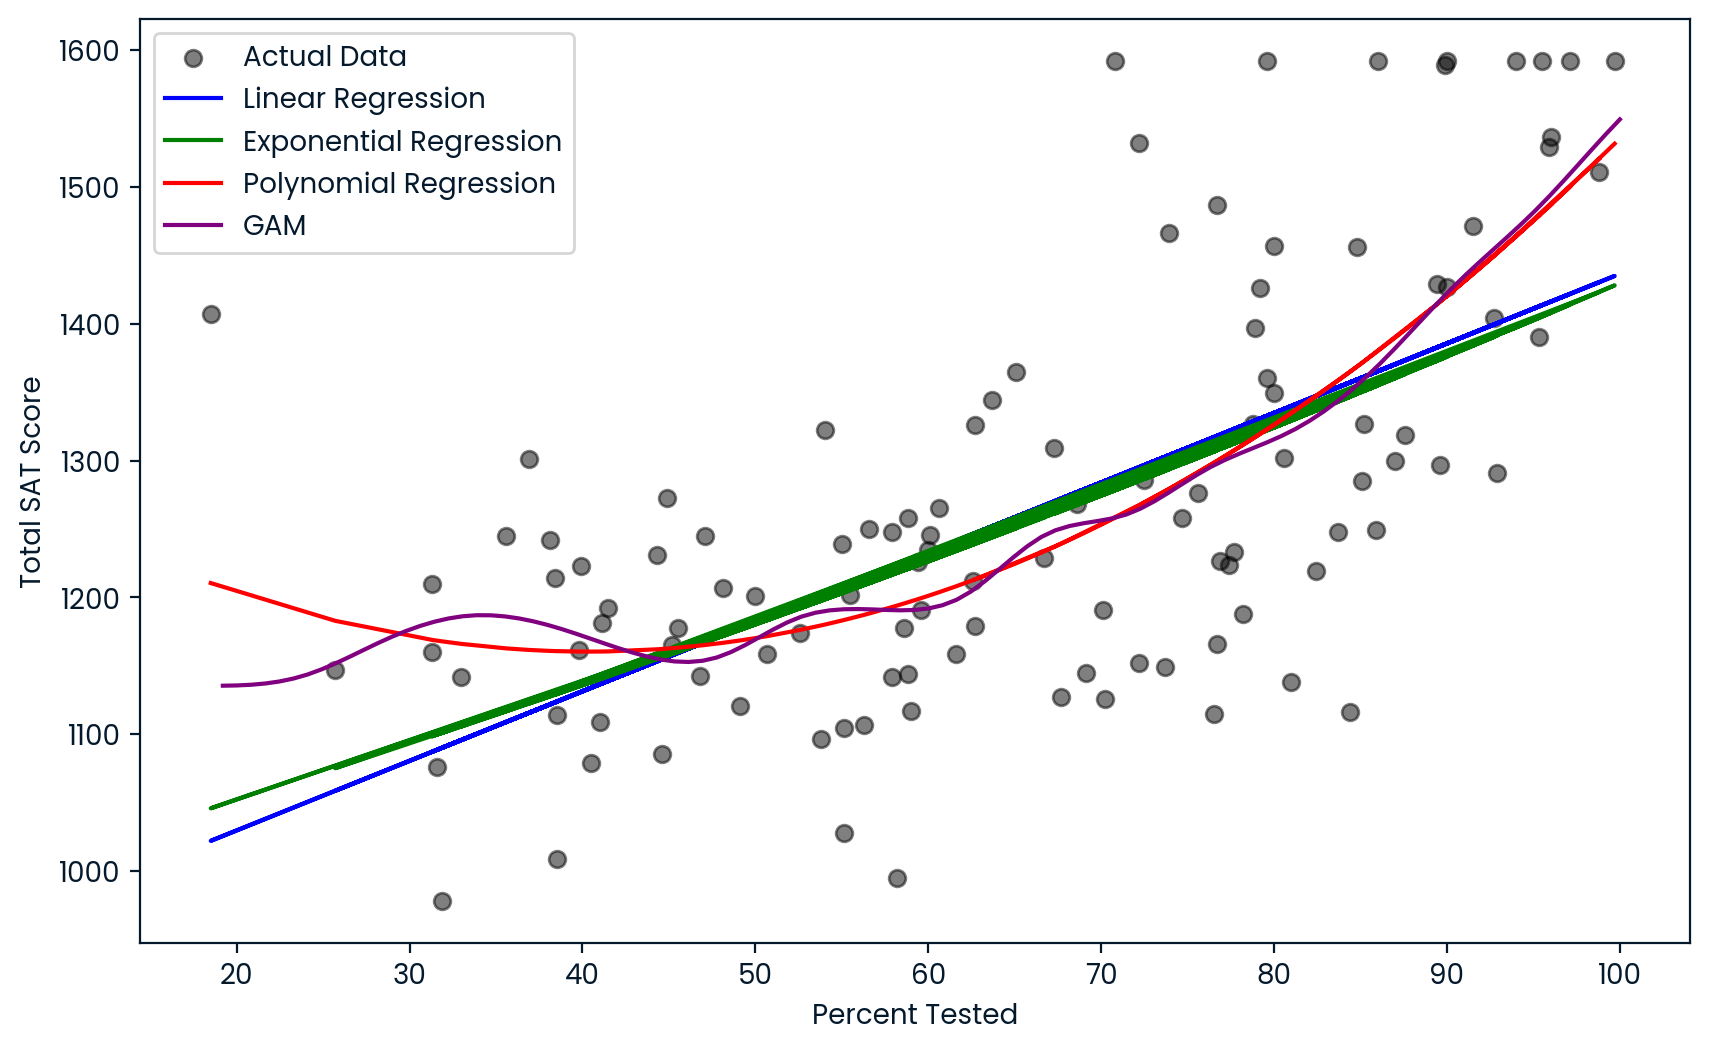

In [20]:
# Defining the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', imputers['mean'], ['percent_tested'])
    ])

# Function to cap the outliers
def cap_outliers(y, lower_bound, upper_bound):
    return np.clip(y, lower_bound, upper_bound)

y_train_capped = cap_outliers(y_train, lb_ytrain, up_ytrain)
y_test_capped = cap_outliers(y_test, lb_ytrain, up_ytrain)

# Function to fit and evaluate a model
def fit_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, r2

# Function to plot model predictions
def plot_predictions(X_test, y_test, y_pred, label, color):
    plt.scatter(X_test, y_test, label='Actual Data', alpha=0.5)
    plt.plot(X_test, y_pred, color=color, label=label)

# Linear Regression
linear_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
y_pred_linear, mse_linear, r2_linear = fit_evaluate_model(linear_pipeline, X_train, y_train_capped, X_test, y_test_capped)
print(f'Linear Regression - MSE: {mse_linear}, R-squared: {r2_linear}')

# Exponential Regression (Transformed Linear Regression)
y_train_log = np.log(y_train_capped)
y_test_log = np.log(y_test_capped)
exp_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge())])
exp_pipeline.fit(X_train, y_train_log)
y_pred_exp_log = exp_pipeline.predict(X_test)
y_pred_exp = np.exp(y_pred_exp_log)
mse_exp = mean_squared_error(y_test_capped, y_pred_exp)
r2_exp = r2_score(y_test_capped, y_pred_exp)
print(f'Exponential Regression - MSE: {mse_exp}, R-squared: {r2_exp}')

# Polynomial Regression
degree = 2
poly_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('regressor', LinearRegression())
])
y_pred_poly, mse_poly, r2_poly = fit_evaluate_model(poly_pipeline, X_train, y_train_capped, X_test, y_test_capped)
print(f'Polynomial Regression - MSE: {mse_poly}, R-squared: {r2_poly}')

# Generalized Additive Model (GAM)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
gam = LinearGAM(s(0)).fit(X_train_preprocessed, y_train_capped)
y_pred_gam = gam.predict(X_test_preprocessed)
mse_gam = mean_squared_error(y_test_capped, y_pred_gam)
r2_gam = r2_score(y_test_capped, y_pred_gam)
print(f'GAM - MSE: {mse_gam}, R-squared: {r2_gam}')

# Sorting the test data and predictions for plotting
sorted_zip = sorted(zip(X_test['percent_tested'], y_pred_poly))
X_test_sorted, y_pred_poly_sorted = zip(*sorted_zip)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test_capped, label='Actual Data', alpha=0.5, color='black')
plt.plot(X_test, y_pred_linear, color='blue', label='Linear Regression')
plt.plot(X_test, y_pred_exp, color='green', label='Exponential Regression')
plt.plot(X_test_sorted, y_pred_poly_sorted, color='red', label='Polynomial Regression')
XX = gam.generate_X_grid(term=0)
plt.plot(XX, gam.predict(XX), color='purple', label='GAM')
plt.xlabel('Percent Tested')
plt.ylabel('Total SAT Score')
plt.legend()
plt.show()



In [21]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import RidgeCV, LassoCV

# Polynomial Regression with cross-validation for degree selection
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_degree = None
best_score = -np.inf

for degree in degrees:
    poly_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('regressor', LinearRegression())
    ])
    scores = cross_val_score(poly_pipeline, X_train, y_train_capped, cv=kf, scoring='r2')
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_degree = degree

print(f'Best degree for Polynomial Regression: {best_degree}, R-squared: {best_score}')




Best degree for Polynomial Regression: 2, R-squared: 0.43796376571902257


In [22]:
gam_ft = LinearGAM(s(0, n_splines=10)).gridsearch(X_train_preprocessed, y_train_capped)
y_pred_gam_ft = gam_ft.predict(X_test_preprocessed)
print(f'GAM - MSE: {mean_squared_error(y_test_capped, y_pred_gam_ft)}, R-squared: {gam_ft.statistics_["pseudo_r2"]["explained_deviance"]}')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


GAM - MSE: 13211.189591651842, R-squared: 0.4480211713985889


### 3. Identifying schools that are outliers using anomaly detection algorithms.

In [23]:
# IQR for outliers detections
outl, lb_outl, up_outl=outliers_detect(schools, 'total_SAT')
display(outl.describe())
print(outl['borough'].value_counts())

Outliers detected (threshold = 1.5): 27


,average_math,average_reading,average_writing,percent_tested,total_SAT
count,27.000000,27.000000,27.000000,26.000000,27.000000
mean,622.925926,592.851852,595.259259,91.215385,1811.037037
std,61.836587,48.142979,50.504830,7.560883,155.335984
min,501.000000,526.000000,522.000000,70.800000,1592.000000
25%,582.000000,550.500000,544.500000,88.275000,1669.500000
50%,625.000000,592.000000,596.000000,94.000000,1804.000000
75%,674.500000,620.500000,629.500000,97.175000,1905.000000
max,754.000000,697.000000,693.000000,99.700000,2144.000000


Manhattan        14
Queens            6
Brooklyn          4
Bronx             2
Staten Island     1
Name: borough, dtype: int64


In [24]:
outl

,school_name,borough,building_code,average_math,average_reading,average_writing,percent_tested,total_SAT
0,"New Explorations into Science, Technology and ...",Manhattan,M022,657,601,601,NaN,1859
5,Bard High School Early College,Manhattan,M097,634,641,639,70.8,1914
14,Institute for Collaborative Education,Manhattan,M475,501,550,541,78.6,1592
18,Millennium High School,Manhattan,M824,577,560,567,94.0,1704
23,Baruch College Campus High School,Manhattan,M874,592,526,531,94.3,1649
26,NYC Lab School for Collaborative Studies,Manhattan,M070,595,550,555,79.8,1700
31,NYC Museum School,Manhattan,M070,560,530,522,90.0,1612
45,Eleanor Roosevelt High School,Manhattan,M855,641,617,631,86.0,1889
48,Beacon High School,Manhattan,M837,583,586,595,82.8,1764
49,Fiorello H. LaGuardia High School of Music and...,Manhattan,M485,592,592,597,88.5,1781


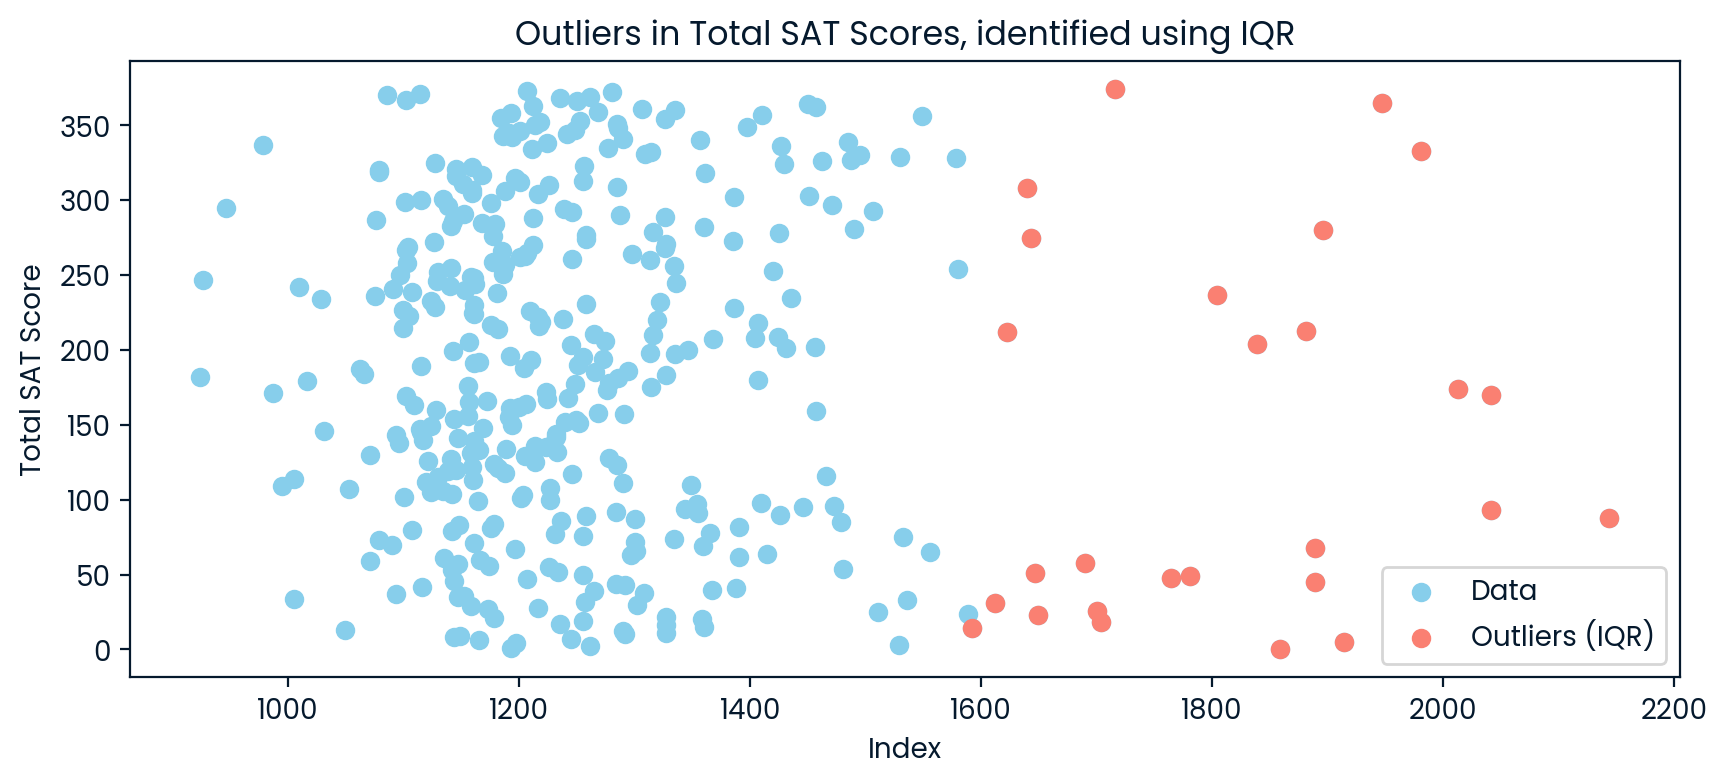

In [25]:
plt.figure(figsize=(10, 4))
plt.scatter(schools['total_SAT'], schools.index, color='skyblue', label='Data')
plt.scatter(outl['total_SAT'],outl.index, color='salmon', label='Outliers (IQR)')
plt.xlabel('Index')
plt.ylabel('Total SAT Score')
plt.title('Outliers in Total SAT Scores, identified using IQR')
plt.legend()
plt.show()
